## Fetch windows, zscores, annotations

In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

In [2]:
import pandas as pd 

pd.set_option('display.max_columns', 50)
pd.set_option('max_colwidth', 50)
pd.set_option('display.max_rows', 100)

def get_windows_scores_annotations():
    filename = f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/mchale.kmerSizes.trainSets.noisy.enhancer-exon.positive-vista-enhancers.bed'
    df = pd.read_csv(filename, sep='\t')
    df['window overlaps positive vista enhancer'] = df['positive-vista-enhancer count'] > 0    
    df['negative new chen zscore'] = -df['new chen zscore']
    return df

windows_scores_annotations = get_windows_scores_annotations()
windows_scores_annotations

,chromosome,start,end,N_observed,N_bar_7_noncoding,N_mean_null_7_noncoding,N_variance_null_7_noncoding,N_bar_1_noncoding,N_mean_null_1_noncoding,N_variance_null_1_noncoding,N_bar_1_noncoding_noisy,N_mean_null_1_noncoding_noisy,N_variance_null_1_noncoding_noisy,N_bar_3_noncoding,N_mean_null_3_noncoding,N_variance_null_3_noncoding,N_bar_3_noncoding_noisy,N_mean_null_3_noncoding_noisy,N_variance_null_3_noncoding_noisy,N_bar_5_noncoding,N_mean_null_5_noncoding,N_variance_null_5_noncoding,N_bar_5_noncoding_noisy,N_mean_null_5_noncoding_noisy,N_variance_null_5_noncoding_noisy,enhancer overlap,merged_exon overlap,window overlaps enhancer,window overlaps merged_exon,"window overlaps (enhancer, merged_exon)",new chen zscore,positive-vista-enhancer count,window overlaps positive vista enhancer,negative new chen zscore
0,chr1,1432000,1433000,260,-0.372778,265.321432,203.777753,1.590921,236.519249,217.834403,1.676924,235.282294,217.264932,-0.247615,263.528599,203.072610,-0.283079,264.038617,203.540686,-0.339806,264.852332,203.910737,-0.340167,264.858613,204.004160,1000.0,NaN,True,False,"(True, False)",4.299894,0,False,-4.299894
1,chr1,1435000,1436000,275,-6.280673,368.627875,222.227572,2.097960,243.596443,224.059444,2.193623,242.210058,223.438246,-7.547130,387.939429,223.937877,-7.609011,389.032484,224.595337,-6.810107,375.796139,219.068492,-6.784165,375.458319,219.269877,1000.0,444.0,True,True,"(True, True)",3.331645,0,False,-3.331645
2,chr1,1449000,1450000,225,0.139977,223.137143,177.111728,0.959620,211.569144,195.888493,1.011359,210.858989,195.501382,0.258359,221.559138,177.372370,0.225283,221.996472,177.748203,0.330975,220.612316,175.743926,0.330023,220.624461,175.781765,NaN,311.0,False,True,"(False, True)",1.817267,0,False,-1.817267
3,chr1,1450000,1451000,313,2.524948,277.859484,193.691881,5.870332,227.882674,210.237742,5.950235,226.828073,209.731395,2.197534,281.968822,199.400099,2.147648,282.634862,199.905291,2.480911,278.322530,195.376527,2.482902,278.288535,195.445943,NaN,758.0,False,True,"(False, True)",1.365863,0,False,-1.365863
4,chr1,1451000,1452000,293,2.951595,252.829443,185.226049,4.803930,223.924244,206.755939,4.877094,222.953222,206.278524,2.367303,260.131776,192.772432,2.332657,260.580640,193.155585,2.725116,255.650992,187.839972,2.724052,255.656435,187.931976,NaN,NaN,False,False,"(False, False)",0.666316,0,False,-0.666316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1786072,chr9,137269000,137270000,210,-3.060479,251.650751,185.210985,-0.657779,219.366052,202.746590,-0.596997,218.491272,202.302491,-3.445370,257.657992,191.337298,-3.474260,258.105694,191.720447,-3.228932,254.283943,188.093965,-3.225423,254.247196,188.190706,1000.0,NaN,True,False,"(True, False)",5.276351,0,False,-5.276351
1786073,chr9,137275000,137276000,296,1.990841,268.077912,196.708291,4.575436,229.442056,211.609361,4.655896,228.354529,211.091617,1.921453,268.932391,198.445131,1.881115,269.472162,198.871703,1.974808,268.272874,197.133316,1.977276,268.231681,197.226096,712.0,NaN,True,False,"(True, False)",2.687348,0,False,-2.687348
1786074,chr9,137282000,137283000,211,-1.612483,232.654005,180.337479,-0.329061,215.647526,199.475805,-0.272968,214.851260,199.058885,-1.919711,237.194349,186.184553,-1.941497,237.514975,186.512986,-1.783906,235.171685,183.598811,-1.783008,235.161871,183.634632,572.0,641.0,True,True,"(True, True)",-0.090791,0,False,0.090791
1786075,chr9,137290000,137291000,224,-0.215971,226.884483,178.380280,0.419311,218.046575,201.585989,0.479479,217.199655,201.151534,-0.682673,233.338243,187.113535,-0.708182,233.697227,187.501923,-0.522518,231.079535,183.571865,-0.521048,231.060300,183.607554,NaN,NaN,False,False,"(False, False)",2.162811,0,False,-2.162811


In [3]:
windows_scores_annotations_coding = windows_scores_annotations[windows_scores_annotations['window overlaps merged_exon'] == True]
windows_scores_annotations_noncoding = windows_scores_annotations[windows_scores_annotations['window overlaps merged_exon'] == False]

## True null distribution is well approximated by a normal distribution 

 

In [4]:
import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')
sys.path.append(f'{CONSTRAINT_TOOLS}/predict-constraint/germline-model')

import matplotlib.pyplot as plt 
plt.rcParams.update({
#     'font.size': 20,
    'figure.figsize': (12, 6)
})

from scipy.stats import norm
import numpy as np 

import seaborn as sns 
sns.set(font_scale=2)

from read_model import read_model
from null_distributions import fetch_distribution_N

TRAIN_SET_LABEL = 'noncoding'
KMER_SIZE = 3 
NUMBER_EXAMPLES = int(1e5)

def read_model_wrapper():
    filename = f'{CONSTRAINT_TOOLS}/dist/model-germline-grch38-Nonly.kmerSize-{KMER_SIZE}.trainSet-{TRAIN_SET_LABEL}.json'
    model = read_model(filename)
    return model

def plot_estimated_vs_actual_null_distribution(df):
    model = read_model_wrapper()
    for (
        region, 
        N_mean_null, 
        N_variance_null
    ) in zip(
        df.apply(lambda row: row['chromosome'] + ':' + str(row['start']) + '-' + str(row['end']), axis=1), 
        df[f'N_mean_null_{KMER_SIZE}_{TRAIN_SET_LABEL}'], 
        df[f'N_variance_null_{KMER_SIZE}_{TRAIN_SET_LABEL}'], 
    ): 
        d = fetch_distribution_N(region, model, NUMBER_EXAMPLES)
        x, y = d['n'], d['p(n)']
        plt.plot(x, y, label='actual null')
        plt.yscale('log')
        plt.xscale('linear')
        plt.xlim([0, 500])
        plt.ylim([1/NUMBER_EXAMPLES, 1e-1])
        plt.xlabel('number of SNVs in window')
        plt.ylabel('probability')

        # no need to multiply pdf by bin size since x is a sequence of consective integers: 
        y = norm.pdf(x, N_mean_null, np.sqrt(N_variance_null)) 
        plt.plot(x, y, label='normal approximation')
        plt.legend()
        
        plt.show()

def fetch_constrained_windows(df): 
    zscore_cutoff = -5
    return df[df[f'N_bar_{KMER_SIZE}_{TRAIN_SET_LABEL}'] < zscore_cutoff]

Sequence for region chr4:41865000-41866000:
CAATTAGTTGTAGAGAAGGACGTGCATTTCACTGGTTGTGAGCAGGGGAGAAGGGCAAGGAGGGAGGAAGGGAGGAAGATAGCCATAACCTTAGATTGGC...
Iterating over region chr4:41865000-41866000 ...
Interrogated 1000/1000 sites in region chr4:41865000-41866000
Number of sites in chr4:41865000-41866000 containing unspecified bases: 0/1000


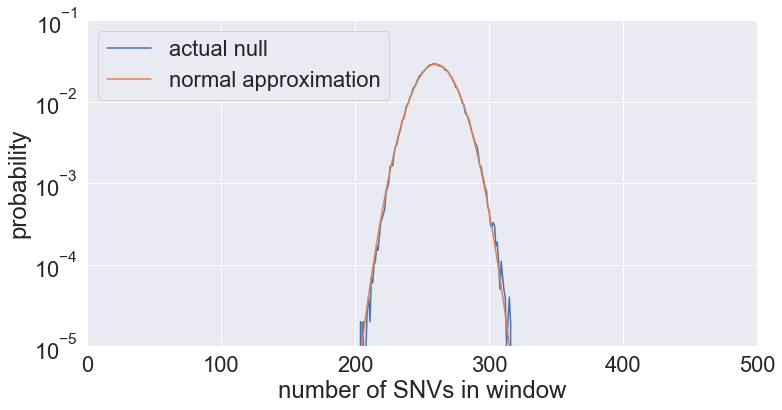

Sequence for region chr14:72096000-72097000:
gctcacgcctgtaatcccagcacttttggaggccgaggcaggtggatcacttgagattaggagttcaagaccagcctggccaacatggtgaaaccccatc...
Iterating over region chr14:72096000-72097000 ...
Interrogated 1000/1000 sites in region chr14:72096000-72097000
Number of sites in chr14:72096000-72097000 containing unspecified bases: 0/1000


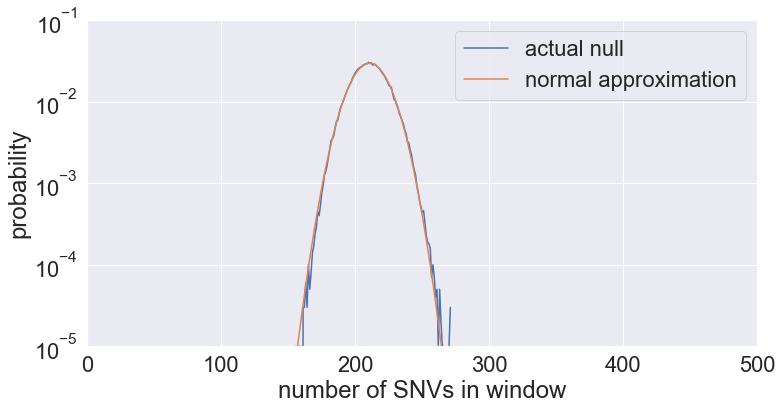

Sequence for region chr11:48138000-48139000:
TTCTGCTCACAGTGCTGACTGTGGCACCTTTATCACTCAGCACCCGTGCACTACTCATTTTCTGCCCTTCTCGCTCCTACCTCTTCCCTTTTTAGCCCAG...
Iterating over region chr11:48138000-48139000 ...
Interrogated 1000/1000 sites in region chr11:48138000-48139000
Number of sites in chr11:48138000-48139000 containing unspecified bases: 0/1000


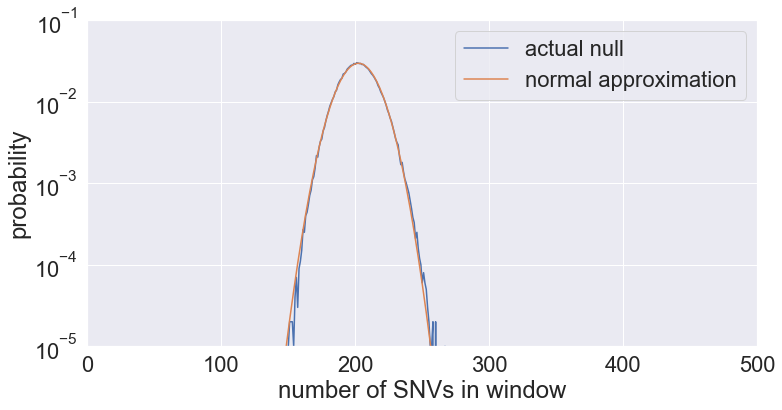

Sequence for region chr5:136899000-136900000:
attagacctttgttcaaatgggtagattgcaaaacttttttcccattctgtaggttgcctgttcactcttatgatagtttcttttgctgtgcagaggctc...
Iterating over region chr5:136899000-136900000 ...
Interrogated 1000/1000 sites in region chr5:136899000-136900000
Number of sites in chr5:136899000-136900000 containing unspecified bases: 0/1000


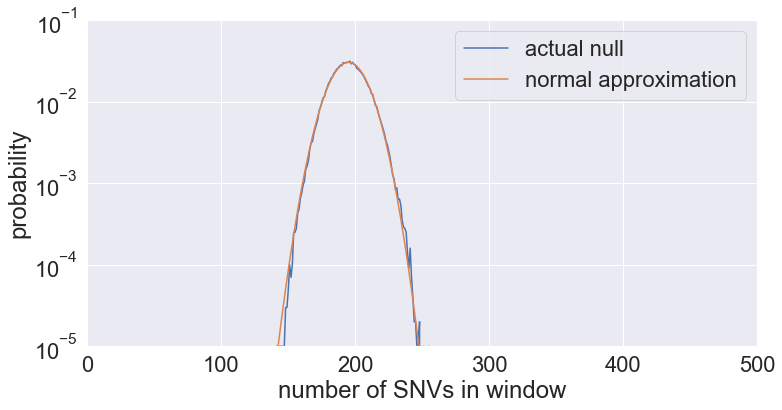

Sequence for region chr3:147308000-147309000:
tccagcatctgttgtttcctgactttttaatgattgtctttctaactggcatgagatggtatctcatcgtggttttgatttgcatctctttaatgaccag...
Iterating over region chr3:147308000-147309000 ...
Interrogated 1000/1000 sites in region chr3:147308000-147309000
Number of sites in chr3:147308000-147309000 containing unspecified bases: 0/1000


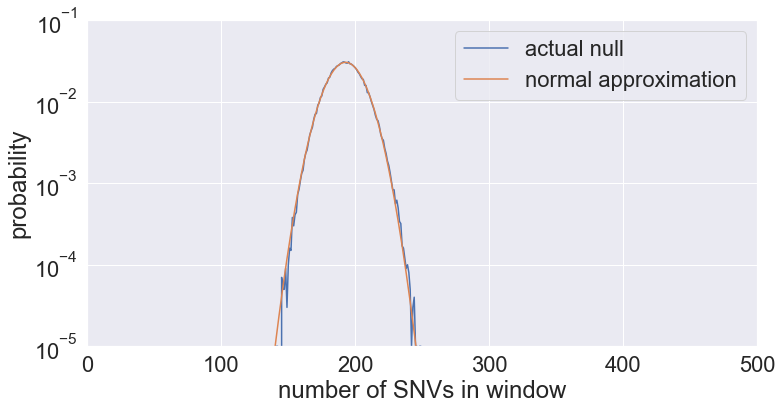

In [5]:
plot_estimated_vs_actual_null_distribution(windows_scores_annotations_noncoding.sample(n=5))

Sequence for region chr17:58939000-58940000:
tggtctcgaactccggacctcaggtaatccacccacctcagcctcccaaagtgctgggattacaggtgtgcaccaccacgcctggccCACTAATTCCGAT...
Iterating over region chr17:58939000-58940000 ...
Interrogated 1000/1000 sites in region chr17:58939000-58940000
Number of sites in chr17:58939000-58940000 containing unspecified bases: 0/1000


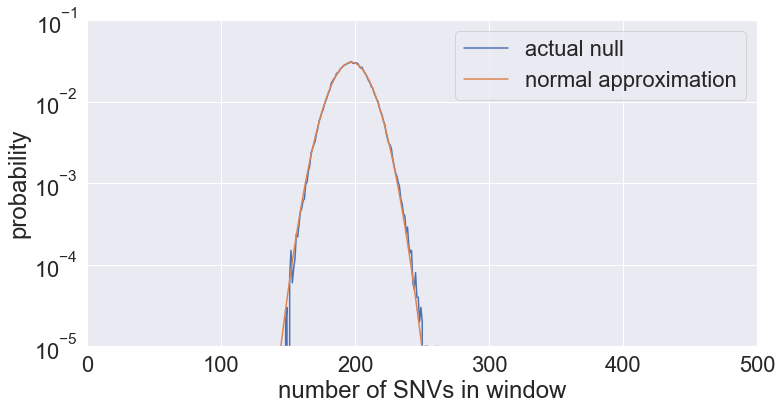

Sequence for region chr19:44847000-44848000:
TCAGGAATGTGGGGAATGTTCCCCCCACCTACCGCAGTAAGGTCTCGAGGAAGAGGCGAGACCACCTCCCTCCCCTATTTTTCCTTCTTCCCGGCTTGGG...
Iterating over region chr19:44847000-44848000 ...
Interrogated 1000/1000 sites in region chr19:44847000-44848000
Number of sites in chr19:44847000-44848000 containing unspecified bases: 0/1000


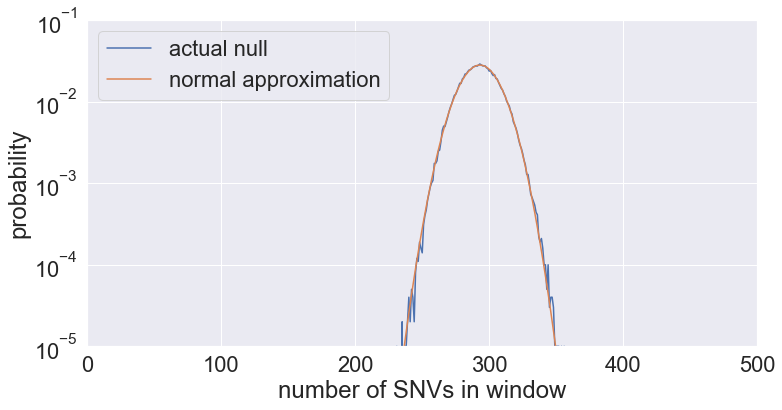

Sequence for region chr17:56812000-56813000:
cacccctctgggagtgggacccaggcatcggaatttaaattccccaggtggttccagaatgtaaccaaagttaagaaacacATTTCTAGAAAAAATACGA...
Iterating over region chr17:56812000-56813000 ...
Interrogated 1000/1000 sites in region chr17:56812000-56813000
Number of sites in chr17:56812000-56813000 containing unspecified bases: 0/1000


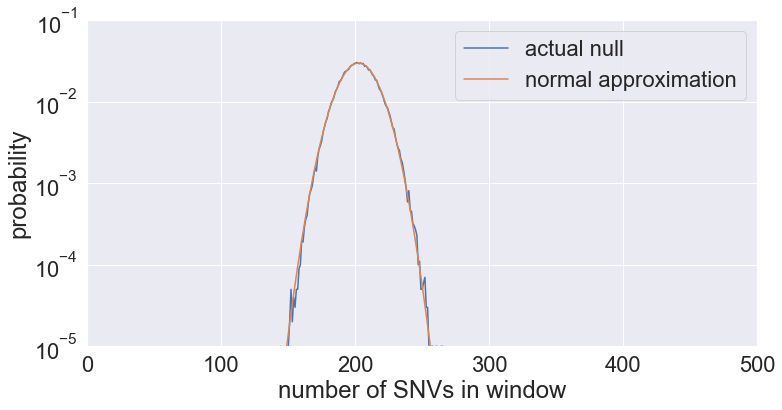

Sequence for region chr19:6101000-6102000:
CCTGCTTTTAACTTAGGCTCTGAATATCAGTTGCCAATGGTTTCTAACAATTTTAAATTTGTCTAGTGCCTTCTCCCCTCTCAACTGTCCACATGACGAT...
Iterating over region chr19:6101000-6102000 ...
Interrogated 1000/1000 sites in region chr19:6101000-6102000
Number of sites in chr19:6101000-6102000 containing unspecified bases: 0/1000


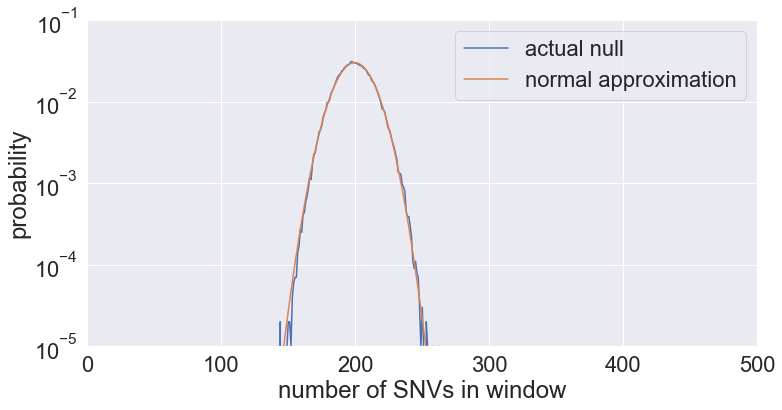

Sequence for region chr2:236179000-236180000:
ATCTCCTGGCTTTAAATTCCGAATAAAAGTCTCAAATATTCCCGGGTCATGGGGGCACTGTCTCATTAAAACCACTCTCGTCCTGAAACTGCAATGCAGA...
Iterating over region chr2:236179000-236180000 ...
Interrogated 1000/1000 sites in region chr2:236179000-236180000
Number of sites in chr2:236179000-236180000 containing unspecified bases: 0/1000


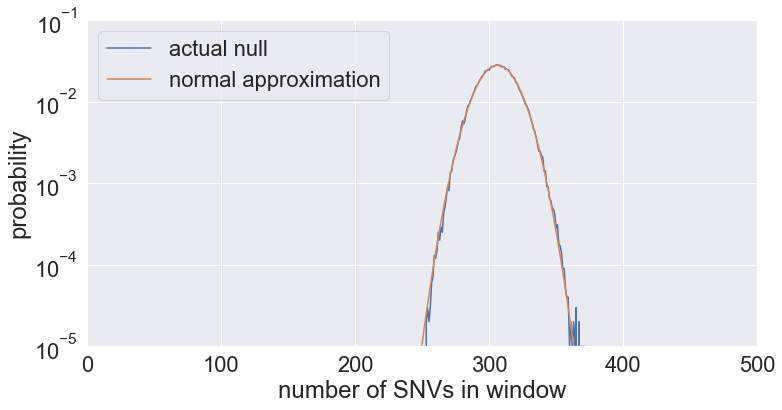

In [6]:
plot_estimated_vs_actual_null_distribution(fetch_constrained_windows(windows_scores_annotations_noncoding).sample(n=5))

## The normal distribution is a good approximation to the null distribution for all windows 



In [ ]:
# TODO: 
# 0. write out math for cross entropy and entropy 
# 1. generate sample SNV counts by factoring out code from fetch_distribution_N
# 2. for each sample, compute probability of sample using normal distribution 
# 3. compute cross entropy using monte carlo approximation and in bits (base 2)
# 4. using true variance, compute entropy of normal distribution (again to base 2 by using change of base rule): https://gregorygundersen.com/blog/2020/09/01/gaussian-entropy/
# 5. visually inspect the absolute and relative value of cross entropy and entropy for a sample of windows
# 6. compute the distribution of (cross_entropy - entropy)/entropy over all windows OR scatter plot cross entropy against entropy 

## TODO

In [7]:
# 2. estimate p-value for each window from the normal distribution 
# 3. do Q-Q plot (c.f., https://github.com/petermchale/QQ-plots/blob/master/qq-plots.pdf)
# 4. COMMIT and add to slide deck